In [ ]:
!pip install xee

In [ ]:
import matplotlib.pyplot as plt
import ee
import geemap
import xarray as xr
import xee

In [ ]:
ee.Authenticate()
ee.Initialize(project = 'air-quality-466614', opt_url = 'https://earthengine-highvolume.googleapis.com')

In [ ]:
gaul = (ee.FeatureCollection("FAO/GAUL/2015/level2")
        .filter(ee.Filter.eq('ADM0_NAME', 'Sri Lanka')))

roi = gaul.geometry()

**Daily Data**

In [ ]:
daily_data = ee.ImageCollection("projects/sat-io/open-datasets/GHAP/GHAP_D1K_PM25").filterDate('2017', '2023')

In [ ]:
daily_dataset_full = xr.open_dataset(
    daily_data,
    engine='ee',
    crs='EPSG:4326',
    geometry=roi,
    scale=0.001
)

In [1]:
from google.colab import files
import pandas as pd

# Upload file manually
uploaded = files.upload()

Saving Daily_Average_2022.csv to Daily_Average_2022.csv


In [3]:
df=pd.read_csv('Daily_Average_2022.csv')

In [4]:
df.head()

,time,b1
0,1/1/2022,1.079143
1,1/2/2022,1.186325
2,1/3/2022,1.457101
3,1/4/2022,2.173230
4,1/5/2022,1.569895


<Figure size 1000x600 with 0 Axes>

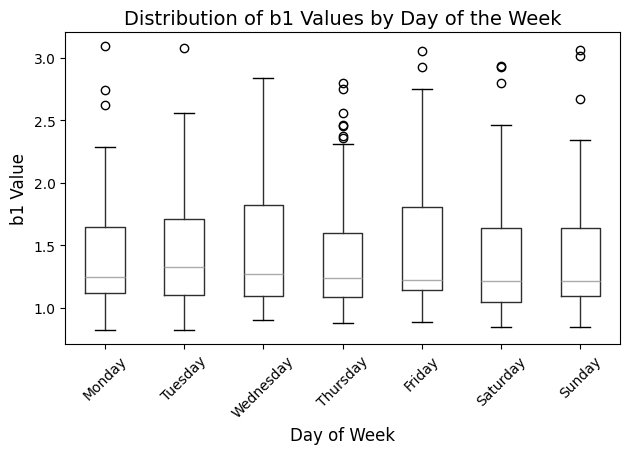

In [32]:
# Convert 'time' column to datetime
df['time'] = pd.to_datetime(df['time'], format='%m/%d/%Y')

# Extract day of the week (0=Monday, 6=Sunday)
df['day_of_week'] = df['time'].dt.dayofweek
df['day_name'] = df['time'].dt.day_name()

# Create ordered categorical variable for proper sorting
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_ordered'] = pd.Categorical(df['day_name'], categories=day_order, ordered=True)

# Create boxplot with Monday to Sunday order
plt.figure(figsize=(10, 6))
df.boxplot(column='b1', by='day_ordered', grid=False)

plt.title("Distribution of b1 Values by Day of the Week")
plt.suptitle("")  # remove default title
plt.xlabel("Day of Week")
plt.ylabel("b1 Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Use following codes repeatedly for 4 quarters

In [ ]:
daily_data = ee.ImageCollection("projects/sat-io/open-datasets/GHAP/GHAP_D1K_PM25").filterDate('2022-10-01', '2022-12-31')

Converting Images into Multidiamentional Structure

---



In [ ]:
daily_dataset = xr.open_dataset(
    daily_data,
    engine='ee',
    crs='EPSG:4326',
    geometry=roi,
    scale=0.001
)

In [ ]:
daily_dataset

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 89, lon: 2358, lat: 3916)
Coordinates:
  * time     (time) datetime64[ns] 712B 2022-01-01 2022-01-02 ... 2022-03-30
  * lon      (lon) float64 19kB 79.52 79.52 79.52 79.52 ... 81.88 81.88 81.88
  * lat      (lat) float64 31kB 5.92 5.921 5.922 5.923 ... 9.833 9.834 9.835
Data variables:
    b1       (time, lon, lat) float32 3GB ...
Attributes:
    crs:      EPSG:4326

In [ ]:
daily_average=daily_dataset.mean(dim=['lat','lon'])*0.1

In [ ]:
daily_df=daily_average.to_dataframe()

In [ ]:
daily_df.to_csv('daily_avg_4th.csv')

In [ ]:
df = daily_df

Available columns: ['b1']
Column 'time' not found. Available columns: ['b1']


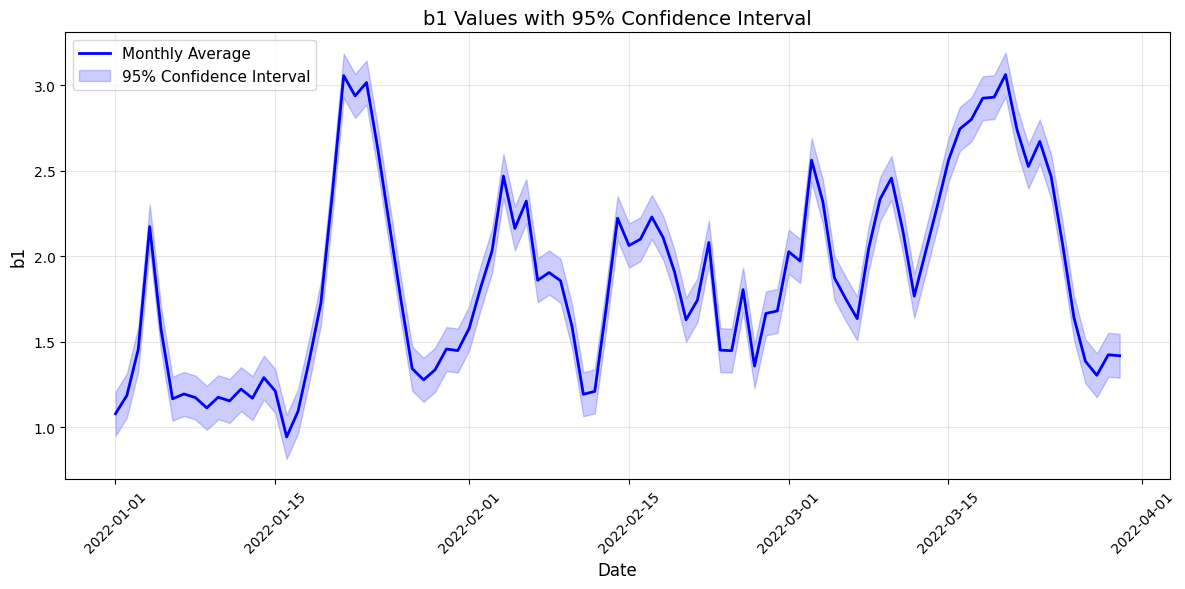

Average b1 value: 1.869
Standard deviation: 0.556
Confidence interval width: ±0.128


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Check what your actual column names are
print("Available columns:", df.columns.tolist())

# Replace 'time' and 'b1' with your actual column names
# For example, if your columns are named 'date' and 'value':
time_column = 'time'  # Change this to your actual time column name
value_column = 'b1'   # Change this to your actual value column name

# Check if the columns exist
if time_column not in df.columns:
    print(f"Column '{time_column}' not found. Available columns: {df.columns.tolist()}")
    # If no time column, use index as x-axis
    time_points = df.index
    time_label = 'Date'
else:
    time_points = df[time_column]
    time_label = time_column

if value_column not in df.columns:
    print(f"Column '{value_column}' not found. Available columns: {df.columns.tolist()}")
    # Use first numeric column if 'b1' doesn't exist
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    if len(numeric_columns) > 0:
        value_column = numeric_columns[0]
        print(f"Using '{value_column}' as value column")
    else:
        raise ValueError("No numeric columns found in DataFrame")

mean_values = df[value_column].values

# Calculate a reasonable CI based on the overall variability of your data
data_std = np.std(mean_values)  # Standard deviation of the means
n = 72  # Your sample size

# Calculate 95% confidence interval
standard_error = data_std / np.sqrt(n)
critical_value = 1.96  # For 95% CI with large sample size

# Create CI for each point
lower_ci = mean_values - critical_value * standard_error
upper_ci = mean_values + critical_value * standard_error

# Plot
plt.figure(figsize=(12, 6))
plt.plot(time_points, mean_values, label='Monthly Average', color='blue', linewidth=2)

# Fill between for confidence interval
plt.fill_between(time_points, lower_ci, upper_ci, color='blue', alpha=0.2,
                 label='95% Confidence Interval')

# Customize the plot
plt.xlabel(time_label, fontsize=12)
plt.ylabel(value_column, fontsize=12)
plt.title(f'{value_column} Values with 95% Confidence Interval', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Rotate x-axis labels only if they are dates/strings
if not isinstance(time_points, pd.RangeIndex):
    plt.xticks(rotation=45)

# Improve layout
plt.tight_layout()
plt.show()

print(f"Average {value_column} value: {np.mean(mean_values):.3f}")
print(f"Standard deviation: {data_std:.3f}")
print(f"Confidence interval width: ±{(np.mean(upper_ci - lower_ci)/2):.3f}")

<Axes: xlabel='time'>

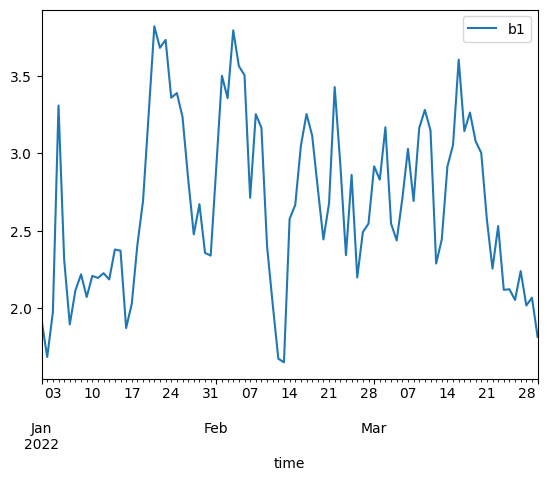

In [ ]:
daily_df.plot()

In [ ]:
import calendar

# 1. Add a coordinate for day of the week (0=Monday, 6=Sunday)
daily_dataset = daily_dataset.assign_coords(
    dayofweek=("time", daily_dataset.time.dt.dayofweek.data)
)

In [ ]:
# 2. Group by dayofweek and take the mean across time
dayofweek_mean = daily_dataset.groupby("dayofweek").mean()

In [ ]:
# 3. Replace numeric dayofweek (0-6) with weekday names
day_labels = [calendar.day_name[i] for i in range(7)]
dayofweek_mean = dayofweek_mean.assign_coords(
    dayofweek=("dayofweek", day_labels)
)

In [ ]:
dayofweek_mean

<xarray.Dataset> Size: 259MB
Dimensions:    (dayofweek: 7, lon: 2358, lat: 3916)
Coordinates:
  * lon        (lon) float64 19kB 79.52 79.52 79.52 79.52 ... 81.88 81.88 81.88
  * lat        (lat) float64 31kB 5.92 5.921 5.922 5.923 ... 9.833 9.834 9.835
  * dayofweek  (dayofweek) <U9 252B 'Monday' 'Tuesday' ... 'Saturday' 'Sunday'
Data variables:
    b1         (dayofweek, lon, lat) float32 259MB nan nan nan ... nan nan nan
Attributes:
    crs:      EPSG:4326

In [ ]:
dayofweek_mean_scaled = dayofweek_mean * 0.1

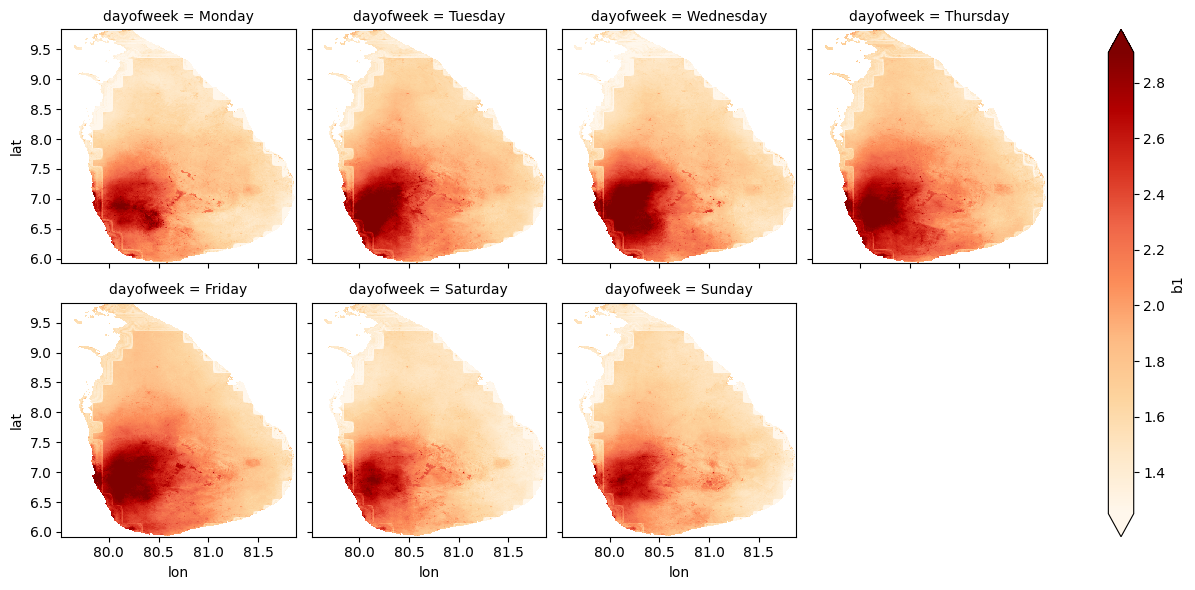

In [ ]:
dayofweek_mean_scaled.b1.plot(
    x="lon",
    y="lat",
    col="dayofweek",
    robust=True,
    cmap="OrRd",
    col_wrap=4
)

plt.savefig("Monthly_PM25.png", dpi=360, bbox_inches="tight")

In [ ]:
# Compute Sri Lanka-wide mean for each weekday
pm25_mean = dayofweek_mean['b1'].mean(dim=['lat', 'lon']).values  # now shape is (7,)

In [ ]:
# Compute Sri Lanka-wide mean for each weekday
pm25_mean_scaled = pm25_mean *0.1  # now shape is (7,)

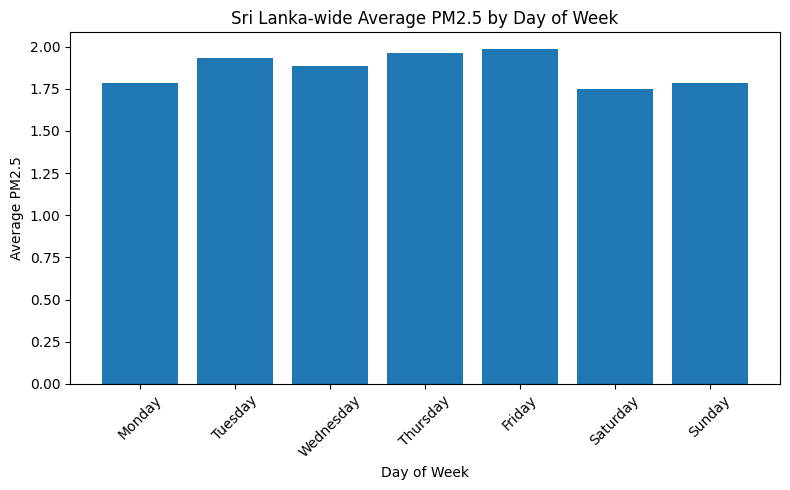

In [ ]:
# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(day_labels, pm25_mean_scaled)
plt.xlabel("Day of Week")
plt.ylabel("Average PM2.5")
plt.title("Sri Lanka-wide Average PM2.5 by Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()